In [13]:
import matplotlib.pyplot as plt
import numpy as np
from flwr.common.typing import NDArray
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from fl4health.PCA.pca import ClientPCA, ServerSideMerger

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser="pandas")
X = MinMaxScaler().fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size=1_000, test_size=100)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

In [15]:
def plot_digits(X: NDArray, title: str) -> None:
    """Small helper function to plot some digits."""
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

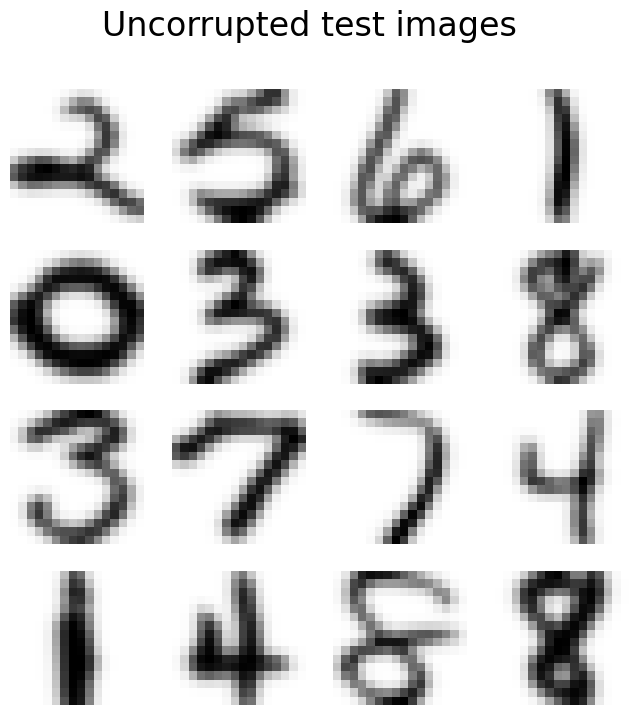

In [16]:
plot_digits(X_test, "Uncorrupted test images")

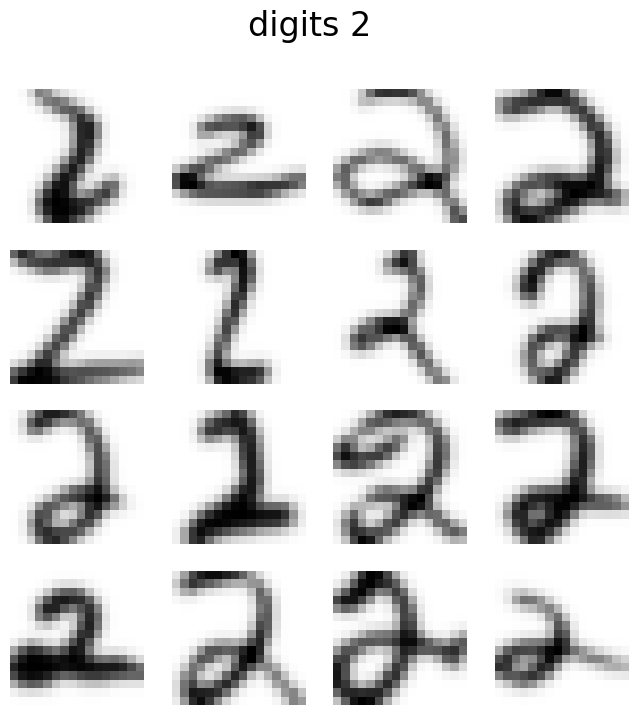

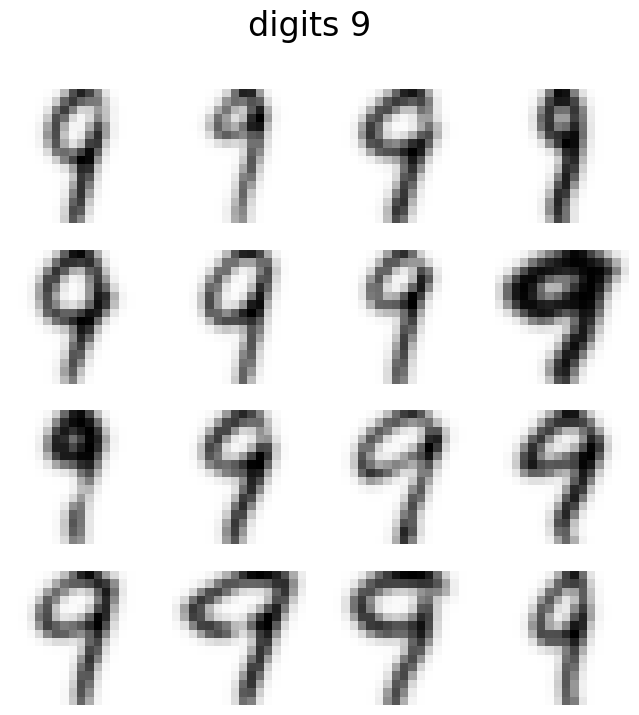

In [21]:
# Find indices of digits 0
digits_2_indices = y_train == "3"

# Access data points with label "0"
X_train_digits_2 = X_train[digits_2_indices]
y_train_digits_2 = y_train[digits_2_indices]


# Find indices of digits 3
digits_9_indices = y_train == "10"

# Access data points with label "0"
X_train_digits_9 = X_train[digits_9_indices]
y_train_digits_9 = y_train[digits_9_indices]


plot_digits(X_train_digits_2, "digits 2")
plot_digits(X_train_digits_9, "digits 9")

In [22]:
client1_pca = ClientPCA(n_components=8)
client2_pca = ClientPCA(n_components=8)

components_digit_2, eigenvals_2 = client1_pca.compute_pc(X_train_digits_2)

components_digit_9, eigenvals_9 = client2_pca.compute_pc(X_train_digits_9)

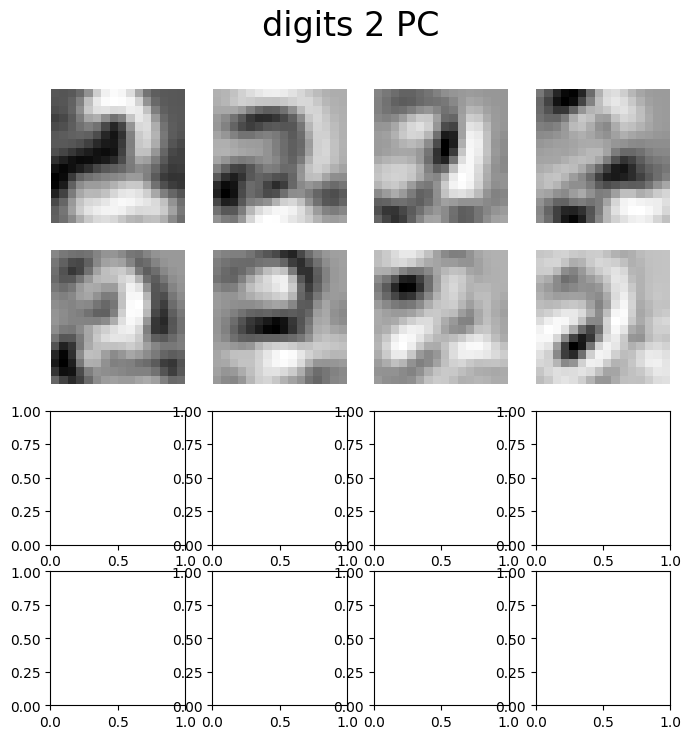

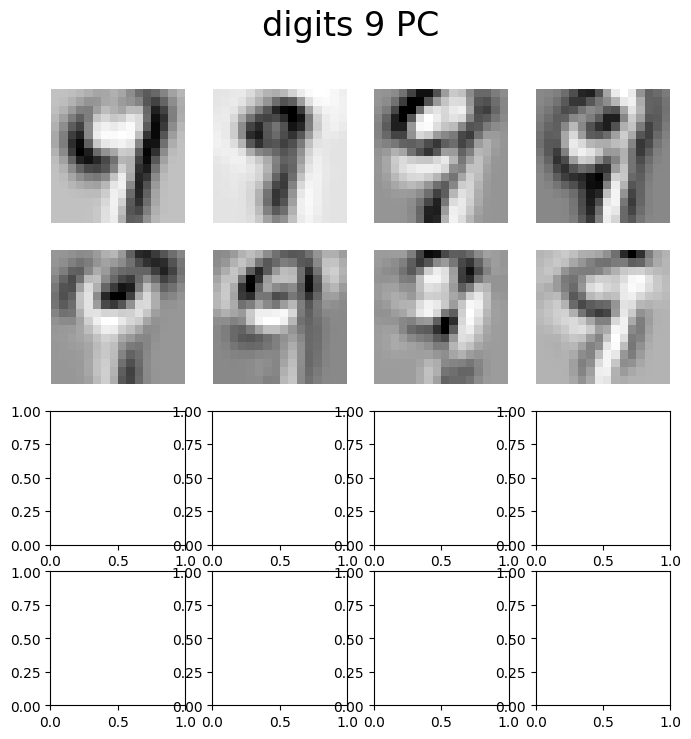

In [23]:
plot_digits(components_digit_2, "digits 2 PC")
plot_digits(components_digit_9, "digits 9 PC")

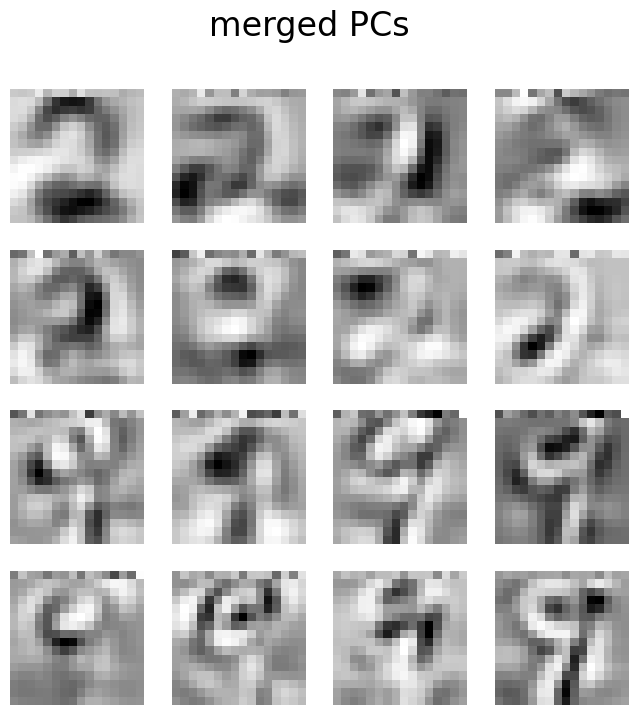

In [28]:
pcs = [components_digit_2, components_digit_9]
eigenvals = [eigenvals_2, eigenvals_9]
merger = ServerSideMerger(pcs, eigenvals)

merger.merge_subspaces()
pcs_new, evals_new = merger.get_principal_components()
plot_digits(pcs_new, "merged PCs")